# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2 : Propiedades en Venta</center>
## <center>Parte 1</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import warnings
warnings.filterwarnings('always')
import shapely.speedups
from IPython.display import Image
import re
from itertools import combinations
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
viviendas_train=pd.read_csv('./TP1/Datasets/viviendas_caba_train.csv').copy()
viviendas_test=pd.read_csv('./TP1/Datasets/viviendas_caba_test.csv').copy()

In [3]:
viviendas = pd.concat([viviendas_train, viviendas_test]).reset_index()

# 1.Procesamiento del Lenguaje Natural

## a) Ampliación del dataset

In [4]:
veces_palabra = {}
indice_de_palabra = {}
for indice in viviendas.index:
    property_title = viviendas.loc[indice,:].property_title.lower()

    if "/" in property_title:
        property_title = property_title.replace("/"," ")
    if "." in property_title:
        property_title = property_title.replace("."," ")
    if "," in property_title:
        property_title = property_title.replace(","," ")
    if "-" in property_title:
        property_title = property_title.replace("-"," ")
    if "ó" in property_title:
        property_title = property_title.replace("ó","o")
    if "!" in property_title:
        property_title = property_title.replace("!"," ")

    property_title = property_title.split()
    
    for palabra in property_title:
        palabra = ''.join(char for char in palabra if char.isalnum())
        if palabra.isnumeric() or len(palabra) < 3:
            continue
        veces_palabra[palabra] = veces_palabra.get(palabra, 0)
        veces_palabra[palabra] +=1 

        indice_de_palabra[palabra]  = indice_de_palabra.get(palabra, list())
        indice_de_palabra[palabra].append(indice)


In [5]:
def agregar_aspecto(aspecto, palabras_clave, dataset):
    for palabra in indice_de_palabra.keys():
        for palabra_clave in palabras_clave:
            if palabra_clave in palabra:
                for i in indice_de_palabra[palabra]:
                    dataset.loc[i, aspecto] = 'sí'
    dataset[aspecto].fillna('unknown', inplace=True)

    
    print(f'cantidad de {aspecto}: { (dataset[aspecto] == "sí").sum() }')

In [6]:
palabras_a_ignorar = set(['departamento', 'depto', 'casa', 'ph', 'venta', 'amb', 'ambientes', 'con'])
for barrio in viviendas_train.barrio:
    for t in barrio.split():
        palabras_a_ignorar.add(t.lower())
for palabra in palabras_a_ignorar:
    if palabra in veces_palabra:
        veces_palabra.pop(palabra)
        indice_de_palabra.pop(palabra)

Ordenamos palabras por cantidad de apariciones para buscar posibles aspectos que sumen valor a nuestro dataset

In [7]:
sorted(veces_palabra.items(),  key=lambda x:x[1])[::-1]
print((sorted(veces_palabra.items(),  key=lambda x:x[1])[::-1])[:50]) #CAMBIE

[('balcon', 12291), ('cochera', 10563), ('monoambiente', 7156), ('terraza', 6564), ('estrenar', 5194), ('patio', 5062), ('amenities', 4632), ('luminoso', 4596), ('excelente', 4338), ('piso', 4099), ('frente', 3789), ('oportunidad', 3193), ('parrilla', 2833), ('apto', 2625), ('muy', 2595), ('vista', 2404), ('dependencia', 2223), ('baulera', 2121), ('semipiso', 1953), ('dpto', 1933), ('dos', 1826), ('reciclado', 1804), ('expensas', 1801), ('alto', 1796), ('hermoso', 1783), ('duplex', 1759), ('torre', 1724), ('profesional', 1713), ('dep', 1584), ('impecable', 1473), ('nuevo', 1445), ('coch', 1428), ('ambiente', 1423), ('hollywood', 1397), ('amplio', 1322), ('pozo', 1300), ('ubicacion', 1216), ('cocheras', 1198), ('propia', 1171), ('dormitorios', 1169), ('edificio', 1135), ('sin', 1125), ('pileta', 1086), ('gran', 1073), ('retasado', 977), ('tipo', 963), ('divisible', 927), ('chico', 923), ('abierta', 923), ('zona', 906)]


Viendo lo anterior buscamos aspectos importantes y palabras claves que los identifiquen para agregarlos al dataset:

+ A estrenar/nuevo
+ Patio/Jardin
+ balcon
+ cochera
+ pileta

In [8]:
agregar_aspecto('a_estrenar', ['estrenar', 'nuevo'], viviendas)
agregar_aspecto('patio_jardin', ['pat', 'jard'], viviendas)
agregar_aspecto('balcon', ['balc'], viviendas)
agregar_aspecto('cochera', ['coche', 'garag'], viviendas)
agregar_aspecto('pileta', ['pil', 'pisc'], viviendas)
agregar_aspecto('parrilla', ['parr'], viviendas)
agregar_aspecto('terraza', ['terra'], viviendas)
agregar_aspecto('monoambiente', ['mono'], viviendas)

cantidad de a_estrenar: 6634
cantidad de patio_jardin: 6569
cantidad de balcon: 12821
cantidad de cochera: 12375
cantidad de pileta: 1842
cantidad de parrilla: 3048
cantidad de terraza: 7517
cantidad de monoambiente: 8109


In [9]:
viviendas

,index,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,...,property_title,geometry,a_estrenar,patio_jardin,balcon,cochera,pileta,parrilla,terraza,monoambiente
0,0,2021-12-15,2021-12-25,-34.555049,-58.490513,Saavedra,Departamento,2.0,1.0,58.0,...,Departamento - Saavedra,POINT (-58.4905135 -34.5550487),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
1,1,2021-05-20,2021-06-05,-34.546991,-58.478553,Saavedra,Departamento,2.0,1.0,48.0,...,Departamento - Saavedra,POINT (-58.4785532 -34.546991),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
2,2,2021-03-20,2021-04-16,-34.570842,-58.491805,Villa Urquiza,Departamento,2.0,1.0,62.0,...,Venta Depto 2 amb Anticipo + Cuotas CAC V. Urq...,POINT (-58.4918048 -34.5708421),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
3,3,2021-07-17,2021-10-16,-34.589251,-58.402106,Recoleta,Departamento,3.0,2.0,60.0,...,Excelente 3 ambientes en venta en Barrio Recoleta,POINT (-58.4021058 -34.5892511),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
4,4,2021-07-02,2022-02-09,-34.626290,-58.437632,Caballito,Departamento,3.0,2.0,67.0,...,VENTA DEPARTAMENTO 3 AMB. EN CABALLITO,POINT (-58.4376325 -34.6262899),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92874,18571,2021-02-13,2021-03-01,-34.594510,-58.413521,Barrio Norte,Departamento,3.0,2.0,60.0,...,VENTA DEPARTAMENTO 3 AMBIENTES BALCÓN FRENTE 3...,POINT (-58.413521 -34.59451),unknown,unknown,sí,unknown,unknown,unknown,unknown,unknown
92875,18572,2021-08-20,2200-12-31,-34.540767,-58.466694,Nuñez,Casa,4.0,3.0,210.0,...,Casa - Nuñez,POINT (-58.4666936 -34.5407667),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
92876,18573,2021-09-08,2021-10-14,-34.586723,-58.402579,Recoleta,Departamento,2.0,1.0,35.0,...,Recoleta 2 amb Oportunidad,POINT (-58.4025792 -34.5867234),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
92877,18574,2021-01-12,2021-06-05,-34.579607,-58.489898,Villa Urquiza,Departamento,4.0,3.0,76.0,...,4 ambientes al contrafrente con balcón y coche...,POINT (-58.4898982 -34.579607),unknown,unknown,sí,sí,unknown,unknown,unknown,unknown


## b) Modelos

### Preprocesamiento

In [10]:
viviendas.loc[:,"a_estrenar"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"patio_jardin"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"balcon"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"cochera"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"pileta"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"parrilla"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"terraza"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"monoambiente"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)

In [11]:
viviendas_train, viviendas_test = train_test_split(viviendas, test_size=0.2, random_state=2)
x_train_ampliado = viviendas_train[['latitud','longitud', 'property_surface_total', 'property_surface_covered', 'a_estrenar', 'patio_jardin', 'balcon', 'cochera', 'pileta', 'parrilla', 'terraza', 'monoambiente']]
x_test_ampliado = viviendas_test[['latitud','longitud', 'property_surface_total', 'property_surface_covered', 'a_estrenar', 'patio_jardin', 'balcon', 'cochera', 'pileta', 'parrilla', 'terraza', 'monoambiente']]

y_train_ampliado = viviendas_train.property_price
y_test_ampliado = viviendas_test.property_price

In [12]:
scaler = MinMaxScaler() 
x_train_ampliado = scaler.fit_transform(x_train_ampliado)
x_test_ampliado = scaler.transform(x_test_ampliado)

### Utilizando los mismos hiperparámetros seleccionados en el TP 1

In [13]:
"""
rand_xgb_params_tp1 = joblib.load('./TP1/Models/rand_xgb')
rand_xgb_params_tp1.fit(x_train_ampliado, y_train_ampliado)
joblib.dump(rand_xgb_params_tp1, './Models/xgb_ampliado_params_tp1')
"""

"\nrand_xgb_params_tp1 = joblib.load('./TP1/Models/rand_xgb')\nrand_xgb_params_tp1.fit(x_train_ampliado, y_train_ampliado)\njoblib.dump(rand_xgb_params_tp1, './Models/xgb_ampliado_params_tp1')\n"

In [14]:
rand_xgb_ampliado_params_tp1 = joblib.load('./Models/xgb_ampliado_params_tp1')
best_xgb_regressor_ampliado_params_tp1 = rand_xgb_ampliado_params_tp1.best_estimator_

In [15]:
#Predicción con mejor estimador
y_pred_test_xgb = best_xgb_regressor_ampliado_params_tp1.predict(x_test_ampliado)

#Coef. de Determinación R2
r2_score_test_xgb = r2_score(y_test_ampliado, y_pred_test_xgb)
print(f'Coef. de Determinación R2: {r2_score_test_xgb}')

#Coef. de Determinación R2 ajustado
n = x_test_ampliado.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test_xgb)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9107357812035757
Coef. de Determinación R2 ajustado: 0.9107165546204522
El error (mse) de test es: 7961554870.09518
El error (rmse) de test es: 89227.54546716603


Vemos que las metricas con el dataset ampliado mejoran considerablemente en comparacion con las del dataset sin ampliar.  
  
  Metricas sin ampliar:  
+    Coef. de Determinación R2: 0.9019645365048344  
+    Coef. de Determinación R2 ajustado: 0.9019434206869473  
+    El error (mse) de test es: 9168434434.619144  
+    El error (rmse) de test es: 95751.94219763453  

In [16]:
def porcentaje_de_cambio_de_metricas(nombre_metrica, metrica_nueva, metrica_anterior):
    porcentaje = round(metrica_nueva*100/ metrica_anterior -100,3)
    if nombre_metrica == 'R2' or 'R2 ajustado':
        if porcentaje < 0:
            print(f'la metrica {nombre_metrica} es un {-porcentaje}% peor')
        else:
            print(f'la metrica {nombre_metrica} es un {porcentaje}% mejor')

    elif nombre_metrica == 'RMSE' or 'MSE':
        if porcentaje > 0:
            print(f'la metrica {nombre_metrica} es un {-porcentaje}% peor')
        else:
            print(f'la metrica {nombre_metrica} es un {porcentaje}% mejor')


Cambio de métricas respecto al dataset sin ampliar (con mismos hiperparametros):

In [17]:
porcentaje_de_cambio_de_metricas('R2', 0.9107357812035757, 0.9019645365048344)
porcentaje_de_cambio_de_metricas('RMSE', 89227.54546716603, 95751.94219763453 )

la metrica R2 es un 0.972% mejor
la metrica RMSE es un 6.814% peor


### Utilizando hiperparametros optimizados con el nuevo dataset ampliado.

decidimos usar GridSearchCV, porque usando RandomSearchCV no obteníamos hiperparámetros distintos a los del dataset sin ampliar

In [18]:
"""#Grilla de Parámetros
params_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

#Clasificador KNN
xgb_regressor_ampliado = xgb.XGBRegressor()

grid_xgb_ampliado_param_tp2 = GridSearchCV(xgb_regressor_ampliado, params_grid, cv=5, scoring='r2')

grid_xgb_ampliado_param_tp2.fit(x_train_ampliado, y_train_ampliado)
joblib.dump(grid_xgb_ampliado_param_tp2, './Models/grid_xgb_ampliado_param_tp2')
"""

"#Grilla de Parámetros\nparams_grid = {\n    'n_estimators': [100, 400, 800],\n    'max_depth': [3, 6, 9],\n    'learning_rate': [0.05, 0.1, 0.20],\n    'min_child_weight': [1, 10, 100]\n    }\n\n#Clasificador KNN\nxgb_regressor_ampliado = xgb.XGBRegressor()\n\ngrid_xgb_ampliado_param_tp2 = GridSearchCV(xgb_regressor_ampliado, params_grid, cv=5, scoring='r2')\n\ngrid_xgb_ampliado_param_tp2.fit(x_train_ampliado, y_train_ampliado)\njoblib.dump(grid_xgb_ampliado_param_tp2, './Models/grid_xgb_ampliado_param_tp2')\n"

In [19]:
grid_xgb_ampliado_param_tp2 = joblib.load('./Models/grid_xgb_ampliado_param_tp2')
best_xgb_ampliado_param_tp2 = grid_xgb_ampliado_param_tp2.best_estimator_

In [20]:
#Predicción con mejor estimador
y_pred_test_xgb = best_xgb_ampliado_param_tp2.predict(x_test_ampliado)

#Coef. de Determinación R2
r2_score_test_xgb = r2_score(y_test_ampliado, y_pred_test_xgb)
print(f'Coef. de Determinación R2: {r2_score_test_xgb}')

#Coef. de Determinación R2 ajustado
n = x_test_ampliado.shape[0] #n = count of rows in your dataset used for train or test
p = 12 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test_xgb)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9127994404557074
Coef. de Determinación R2 ajustado: 0.912743069895209
El error (mse) de test es: 7777495270.509185
El error (rmse) de test es: 88190.10868861193


In [22]:
performance_train = pd.DataFrame({'Valor Real': y_test_ampliado,
                            'Prediccion': y_pred_test_xgb.round(),
                            'Error': y_test_ampliado - y_pred_test_xgb.round()})
performance_train.head()

,Valor Real,Prediccion,Error
63184,69900.0,78191.0,-8291.0
62628,108000.0,143328.0,-35328.0
75408,75000.0,104908.0,-29908.0
49022,420000.0,675072.0,-255072.0
29265,49900.0,56399.0,-6499.0


c:\Users\iankl\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1080: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = self.plt.cm.get_cmap(cmap)
c:\Users\iankl\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


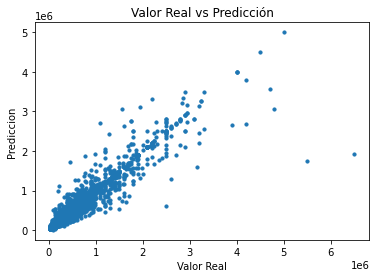

In [23]:
scatter_real_predict_train = performance_train.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


Cambio de métricas buscando nuevos hiperparametros

In [24]:
porcentaje_de_cambio_de_metricas('R2', 0.9127994404557074, 0.9107357812035757)
porcentaje_de_cambio_de_metricas('RMSE', 88190.10868861193, 89227.54546716603)

la metrica R2 es un 0.227% mejor
la metrica RMSE es un 1.163% peor


# 4. Conclusiones

### opciones que hubiesemos explorado y quedaron fuera del alcance de este trabajo

+ En cuanto a la primera parte (Ampliación del dataset), se pudo haber usado algun métodos de extracción de conocimiento como lo son ExtrHech, ArgOE, DepOE o ECMes. También se pudieron haber añadido al dataset columnas como cantidad de baños o expensas las cuales tendrían valores extraídos del texto de property_title.

+ En cuanto a la segunda parte (Redes Neuronales), se pudo haber probado una grilla con mayor cantidad de hiperparámetros, como por ejemplo reguladores (L1 y L2), early stopping y dropout. Tambien podríamos haber probado otras distintas combinaciones de capas ocultas de neuronas además de probar otro tipo de capas. Se pudo haber probado correr más iteraciones mezclando hiperparámetros.
Otra cosa que quedó fuera de nuestro alcance es hacer un ensamble entre nuestros mejores modelos de redes

+ En cuanto a la tercera parte podríamos haber usado para los ensambles algunos de nuestros modelos de redes




### Aspectos relevantes:

+ Parte 1: Procesamiento de Lenguaje Natural


+ Parte 2: Redes Neuronales


+ Parte 3: Ensambles de Modelos

# 3. Ensamble de Modelos

## Voting

### Voting sobre modelos nuevos

In [ ]:
import pandas as pd
import numpy as np 

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import joblib

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.ensemble import VotingClassifier


In [ ]:
#Importo los datos de entrenamiento y prueba de nuestro Random Forest

y_train = pd.read_csv('./TP1/Datasets/y_train_property_type.csv').copy()
y_test = pd.read_csv('./TP1/Datasets/y_test_property_type.csv').copy()

x_train = pd.read_csv('./TP1/Datasets/x_train_property_type.csv').copy()
x_test = pd.read_csv('./TP1/Datasets/x_test_property_type.csv').copy()


Voy a evaluar distintos clasificadores para ver cual me conviene para obtener mejores metricas.

In [ ]:

# Predicciones con decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc = dtc.fit(x_train, y_train)
y_pred_dtc = dtc.predict(x_test)


# Predicciones con logistic regression model
lr = LogisticRegression()
lr = lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)


# Predicciones con naive bayes model
gnb = GaussianNB()
gnb = gnb.fit(x_train, y_train)
y_pred_gnb = gnb.predict(x_test)

# Predicciones con modelo AdaBoost
ada_boost_clf = AdaBoostClassifier()
ada_boost_clf.fit(x_train, y_train)
y_pred_ada = ada_boost_clf.predict(x_test)

# Predicciones con modelo Random Forest
rnd_clf = RandomForestClassifier()
rnd_clf.fit(x_train, y_train)
y_pred_rnd = rnd_clf.predict(x_test)

# Predicciones con modelo KNN
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_train)
y_pred_knn = knn_clf.predict(x_test)

Imprimo los resultados.

In [ ]:
# evaluating the models based on their f-1 scores
f1_dtc = f1_score(y_test, y_pred_dtc,average='weighted')
f1_lr = f1_score(y_test, y_pred_lr,average='weighted')
f1_gnb = f1_score(y_test, y_pred_gnb,average='weighted')
f1_rnd = f1_score(y_test, y_pred_rnd,average='weighted')
f1_knn = f1_score(y_test, y_pred_knn,average='weighted')
f1_ada = f1_score(y_test, y_pred_ada,average='weighted')

# print the f-1 scores
print('F1-score of decision tree classifier: {}'.format(np.round(f1_dtc,4)))
print('F1-score of support vector machine: {}'.format(np.round(f1_lr,4)))
print('F1-score of naive bayes classifier: {}'.format(np.round(f1_gnb,4)))
print('F1-score of random forest classifier: {}'.format(np.round(f1_rnd,4)))
print('F1-score of KNN classifier: {}'.format(np.round(f1_knn,4)))
print('F1-score of AdaBoost classifier: {}'.format(np.round(f1_ada,4)))

F1-score of decision tree classifier: 0.7051
F1-score of support vector machine: 0.5452
F1-score of naive bayes classifier: 0.3733
F1-score of random forest classifier: 0.745
F1-score of KNN classifier: 0.6116
F1-score of AdaBoost classifier: 0.5932


Aca podemos ver que los mejores 3 modelos fueron los de Decision Tree Classifier, Random Forest Classifier y KNN. Procedo a realizar el Voting con dichos tres modelos. Para obtener mejores resultados, tambien voy a evaluar realizando una votacion de tipo Hard y una de tipo Soft y utilizar la que mejores resultados de.

In [ ]:
#Creo clasificadores

dtc_clf = DecisionTreeClassifier()
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

#Creo ensemble de Votación Hard
vot_clf_h = VotingClassifier(estimators = [('dtc', dtc_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

#Creo ensemble de Votación Soft
vot_clf_s = VotingClassifier(estimators = [('dtc', dtc_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'soft')


#Entreno ambos ensembles
vot_clf_h.fit(x_train, y_train)
vot_clf_s.fit(x_train, y_train)

#Evaluo en conjunto de test
pred_h = vot_clf_h.predict(x_test)
pred_s = vot_clf_s.predict(x_test)

In [ ]:
#Calculo accuracy
print("RESULTADOS HARD VOTING:\n")
print('Accuracy Score: {}'.format(accuracy_score(y_test, pred_h)))
print('F1-score: {}'.format(f1_score(y_test, pred_h,average="weighted")))
print("Precision Score : ",precision_score(y_test,pred_h,pos_label='positive',average="weighted"))
print("Recall Score :" , recall_score(y_test, pred_h, pos_label='positive',average="weighted"))

print("\nRESULTADOS SOFT VOTING:\n")
print('Accuracy Score: {}'.format(accuracy_score(y_test, pred_s)))
print('F1-score: {}'.format(f1_score(y_test, pred_s,average="weighted")))
print("Precision Score: ",precision_score(y_test,pred_s,pos_label='positive',average="weighted"))
print("Recall Score:" , recall_score(y_test, pred_s, pos_label='positive',average="weighted"))

RESULTADOS HARD VOTING:

Accuracy Score: 0.7311584840654608
F1-score: 0.7306882097343488
Precision Score :  0.7318538462448096
Recall Score : 0.7311584840654608

RESULTADOS SOFT VOTING:

Accuracy Score: 0.7250753660637381
F1-score: 0.7245058675971877
Precision Score:  0.7253093651878666
Recall Score: 0.7250753660637381


Concluimos que conviene utilizar el metodo de Hard voting.

### Voting sobre nuestros modelos 

In [ ]:
import pandas as pd
import numpy as np 

import warnings
warnings.filterwarnings('ignore')

import joblib

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import VotingClassifier

In [ ]:
#Importo los datos de entrenamiento y prueba de nuestro Random Forest

y_train = pd.read_csv('./TP1/Datasets/y_train_property_type.csv').copy()
y_test = pd.read_csv('./TP1/Datasets/y_test_property_type.csv').copy()

x_train = pd.read_csv('./TP1/Datasets/x_train_property_type.csv').copy()
x_test = pd.read_csv('./TP1/Datasets/x_test_property_type.csv').copy()

In [ ]:
#Importo los modelos del TP1

knn_clf = joblib.load('./TP1/Models/knn_mejor_performance')
rnd_clf = joblib.load('./TP1/Models/rf_mejor_performance')
dtc_clf = joblib.load('./TP1/Models/arbol_mejor_performance')

In [ ]:
# Predicciones con modelo Knn
knn_clf.fit(x_train, y_train)
y_pred_knn = knn_clf.predict(x_test)

# Predicciones con modelo Random Forest
rnd_clf.fit(x_train, y_train)
y_pred_rnd = rnd_clf.predict(x_test)

# Predicciones con modelo DTC
dtc_clf.fit(x_train, y_train)
y_pred_dtc = dtc_clf.predict(x_test)


# evaluating the models based on their f-1 scores
f1_dtc = f1_score(y_test, y_pred_dtc,average='weighted')
f1_rnd = f1_score(y_test, y_pred_rnd,average='weighted')
f1_knn = f1_score(y_test, y_pred_knn,average='weighted')

# print the f-1 scores
print('F1-score of decision tree classifier: {}'.format(np.round(f1_dtc,4)))
print('F1-score of random forest classifier: {}'.format(np.round(f1_rnd,4)))
print('F1-score of KNN classifier: {}'.format(np.round(f1_knn,4)))

F1-score of decision tree classifier: 0.7051
F1-score of random forest classifier: 0.7449
F1-score of KNN classifier: 0.6748


Tras predecir los modelos individualmente, vamos a realizar el Voting para ver si mejora.

In [ ]:
#Creo ensemble de Votación Hard
vot_clf_h = VotingClassifier(estimators = [('dtc', dtc_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

#Creo ensemble de Votación Soft
vot_clf_s = VotingClassifier(estimators = [('dtc', dtc_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'soft')


#Entreno ambos ensembles
vot_clf_h.fit(x_train, y_train)
vot_clf_s.fit(x_train, y_train)

#Evaluo en conjunto de test
pred_h = vot_clf_h.predict(x_test)
pred_s = vot_clf_s.predict(x_test)



#Calculo accuracy
print("RESULTADOS HARD VOTING:\n")
print('Accuracy Score: {}'.format(accuracy_score(y_test, pred_h)))
print('F1-score: {}'.format(f1_score(y_test, pred_h,average="weighted")))
print("Precision Score : ",precision_score(y_test,pred_h,pos_label='positive',average="weighted"))
print("Recall Score :" , recall_score(y_test, pred_h, pos_label='positive',average="weighted"))

print("\nRESULTADOS SOFT VOTING:\n")
print('Accuracy Score: {}'.format(accuracy_score(y_test, pred_s)))
print('F1-score: {}'.format(f1_score(y_test, pred_s,average="weighted")))
print("Precision Score: ",precision_score(y_test,pred_s,pos_label='positive',average="weighted"))
print("Recall Score:" , recall_score(y_test, pred_s, pos_label='positive',average="weighted"))

KeyboardInterrupt: 

Concluimos que conviene utilizar el metodo de Hard voting.

### Conclusiones Voting

Como podemos ver tras comparar los dos modelos, nos da una metrica superior el Voting realizado con los modelos del TP1. Esto se debe a que dichos modelos fueron ajustados de mejor manera y son mas precisos. Sin embargo, algo que nos llamo la atención es que los modelos de Random Forest obtienen mejores resultados que el propio Voting.

## Stacking

In [ ]:
import numpy as np 
import pandas as pd
from collections import defaultdict
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV

warnings.filterwarnings('ignore')


from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
#Importo los datos de entrenamiento y prueba de nuestro Random Forest

y_train = pd.read_csv('./TP1/Datasets/y_train_property_type.csv').copy()
y_test = pd.read_csv('./TP1/Datasets/y_test_property_type.csv').copy()

x_train = pd.read_csv('./TP1/Datasets/x_train_property_type.csv').copy()
x_test = pd.read_csv('./TP1/Datasets/x_test_property_type.csv').copy()


In [ ]:
#Funcion para evaluar los modelos 5fold -CV (2 repeticiones)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [ ]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [ ]:
#Modelos Base
base_models = {'random_forest':RandomForestClassifier(n_estimators=50),
               'dtc': DecisionTreeClassifier(),
               'knn': KNeighborsClassifier(n_neighbors=11)
               } 

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train, y_train)
    model_scores[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   37.5s finished


Evaluating dtc


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.4s finished


Evaluating knn


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  2.8min finished


In [ ]:
from sklearn.ensemble import StackingClassifier

#Modelos Base
base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('dtc', DecisionTreeClassifier()),
               ('knn', KNeighborsClassifier(n_neighbors=11))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True,
                                    cv=5,
                                    verbose=2)

In [ ]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, x_train, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 25.7min finished


In [ ]:
#Grafico performance
plot_results(model_scores, name='stacking_model_cv')

Tras multiples pruebas de modelos, concluimos que estos tres (Random Forest, Decision Tree y KNN) son los mejores modelos para elegir. Fueron los que mejores métricas nos dieron.

In [ ]:
#Evaluo en conjunto de test
#stacking_model.fit(x_train,y_train).score(x_test,y_test)
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)


print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred_st)))
print('F1-score: {}'.format(f1_score(y_test, y_pred_st,average="weighted")))
print("Precision Score: ",precision_score(y_test,y_pred_st,pos_label='positive',average="weighted"))
print("Recall Score:" , recall_score(y_test, y_pred_st, pos_label='positive',average="weighted"))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished


Accuracy Score: 0.7502153316106804
F1-score: 0.7490939091565331
Precision Score:  0.7535181655904228
Recall Score: 0.7502153316106804


In [ ]:
import joblib
joblib.dump(base_models, './Models/base_models')
joblib.dump(model_scores, './Models/model_scores')
joblib.dump(meta_model, './Models/meta_model')
joblib.dump(stacking_model, './Models/stacking_model')
joblib.dump(stacking_scores, './Models/stacking_scores')
joblib.dump(y_pred_st, './Models/y_pred_st')

['./Models/y_pred_st']

A modo de conclusion, podemos decir que, como era de esperarse, las metricas de Stacking fueron superiores a las de Voting.